# Ward Linkage Clustering – Implementation Notebook

This notebook implements **Agglomerative Hierarchical Clustering with Ward linkage** for the CS6140 Group Problem Set #1 & #2.

It is organized to satisfy the *implementation* requirements of the assignment:
- data preprocessing for a real‑world datasets  
- dimensionality reduction  
- Ward linkage clustering  
- visualisation (dendrograms + 2D PCA scatterplots)  
- cluster validation with multiple internal metrics


## 1. Dataset Selection and Justification

I use **a real-world, unlabeled datasets** that are suitable for clustering:

**Customer Personality Analysis (marketing_campaign.csv) – Kaggle**
   - Rows correspond to individual customers.
   - Features include demographics, past purchases and campaign response.
   - This dataset is naturally unlabeled, making it suitable for clustering approaches that aim to segment customers based on behaviour or attributes.

The dataset contains **continuous, numeric features**, which makes it well-suited for Ward linkage clustering.  
Ward linkage relies on **Euclidean distance** and aims to minimise the increase in within-cluster sum of squared errors (SSE), meaning it performs best when variables are numeric and standardised.

In [1]:
import kagglehub

# Download Customer Personality dataset
customer_path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")
print("Customer dataset path:", customer_path)


Using Colab cache for faster access to the 'customer-personality-analysis' dataset.
Customer dataset path: /kaggle/input/customer-personality-analysis


## 2. Customer Personality Dataset – Preprocessing, PCA and Ward Clustering

### 2.1 Preprocessing and Feature Engineering
The following steps are applied to `marketing_campaign.csv`:

- **Read data** from the KaggleHub path using a tab separator.  
- **Drop rows with missing values** (`df.dropna()`), so that distance computations for clustering are not affected by NaNs.  
- **Feature engineering**:
  - `Age` is computed as `2024 - Year_Birth`.
  - `TotalSpend` is the sum of several product‑specific spending columns.
  - `Kids` combines the number of children and teenagers in the household.
- **Feature selection**: I keep only relevant **numeric** variables such as `Income`, `Recency`, `TotalSpend`, `NumStorePurchases`, `NumWebPurchases`, `NumWebVisitsMonth`, `Age`, and `Kids`.
- **Standardisation**: I apply `StandardScaler` to obtain zero‑mean, unit‑variance features.  
  This is essential because Ward linkage uses Euclidean distance – features on larger scales would otherwise dominate the clustering.

### 2.2 Ward Linkage Clustering
I use `AgglomerativeClustering` with:
- `linkage='ward'` (minimises the increase in within‑cluster SSE at each merge),
- a chosen number of clusters `n_clusters = 2` for this notebook.

A dendrogram based on `scipy.cluster.hierarchy.linkage` and `dendrogram` is plotted to visualise the hierarchical structure and the merges produced by Ward’s method.

### 2.3 Cluster Validation
To evaluate the clustering I compute three internal validation indices:

- **Silhouette Score** – values close to 1 indicate well‑separated, compact clusters; values near 0 mean overlapping clusters.  
- **Davies–Bouldin Index** – lower values indicate better clustering (clusters are compact and far apart).  
- **Calinski–Harabasz Index** – higher values indicate better cluster separation relative to within‑cluster dispersion.

These metrics help compare Ward linkage against other clustering algorithms in the group assignment and across different datasets.

### 2.4 Dimensionality Reduction for Visualisation
I apply **PCA with 2 components** to the standardised feature matrix:

- PCA preserves as much variance as possible in two dimensions.
- It provides a convenient 2D embedding to visualise the resulting clusters.

I then plot a 2D scatterplot of the PCA components, coloured by the Ward cluster labels.

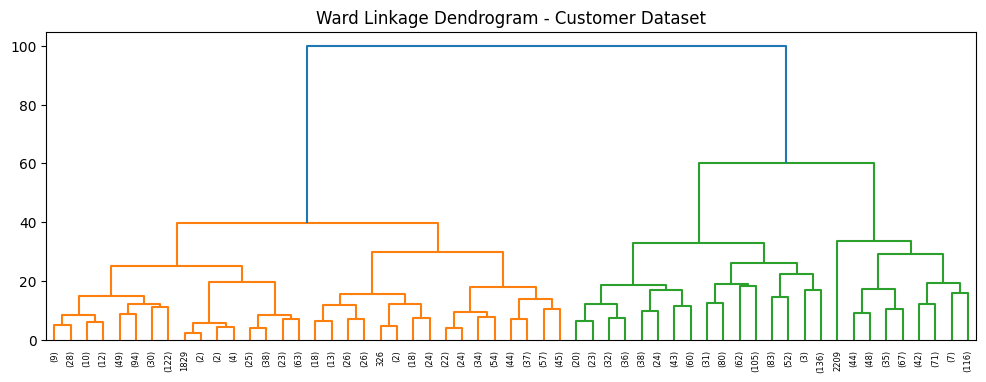


--- Customer Dataset (Ward) ---
Silhouette Score: 0.2567
Davies-Bouldin Index: 1.4493
Calinski-Harabasz Index: 863.5161


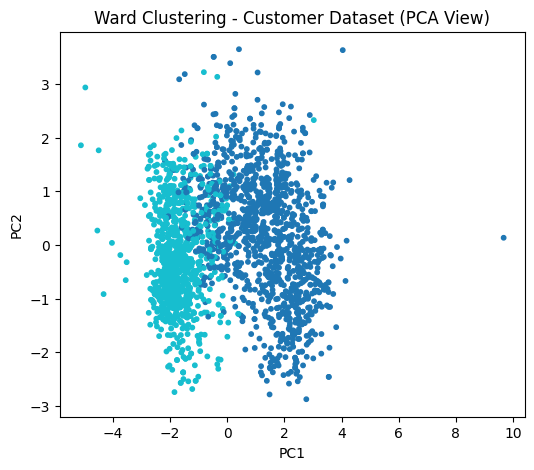

In [2]:
# ===============================
# WARD LINKAGE - CUSTOMER DATASET
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# Load data from kagglehub path
customer_data_file = customer_path + "/marketing_campaign.csv"
df = pd.read_csv(customer_data_file, sep="\t")

# Cleaning
df = df.dropna()

# Feature Engineering
df["Age"] = 2024 - df["Year_Birth"]
df["TotalSpend"] = df[["MntWines","MntFruits","MntMeatProducts","MntFishProducts",
                       "MntSweetProducts","MntGoldProds"]].sum(axis=1)
df["Kids"] = df["Kidhome"] + df["Teenhome"]

# Select useful numeric features
features = [
    "Income", "Recency", "TotalSpend", "NumStorePurchases",
    "NumWebPurchases", "NumWebVisitsMonth", "Age", "Kids"
]

X = df[features]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dendrogram
plt.figure(figsize=(12, 4))
Z = linkage(X_scaled, method='ward')
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Ward Linkage Dendrogram - Customer Dataset")
plt.show()

# Choose k=2
cluster_model = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels = cluster_model.fit_predict(X_scaled)

# Evaluation
sil = silhouette_score(X_scaled, labels)
dbi = davies_bouldin_score(X_scaled, labels)
ch = calinski_harabasz_score(X_scaled, labels)

print("\n--- Customer Dataset (Ward) ---")
print("Silhouette Score:", round(sil, 4))
print("Davies-Bouldin Index:", round(dbi, 4))
print("Calinski-Harabasz Index:", round(ch, 4))

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=10)
plt.title("Ward Clustering - Customer Dataset (PCA View)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
